In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

#machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, 
    r2_score, mean_absolute_percentage_error
)
import xgboost as xgb
import lightgbm as lgb
import shap

import sys
sys.path.append('..')
import config

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seed
np.random.seed(config.RANDOM_SEED)

print("Libraries imported successfully")

Configuration loaded successfully!
Project root: C:\Users\hp\Desktop\gaf\Ghana-Armed-Forces-Personnel-Deployment-and-Attrition-Risk-Modeling
Random seed: 42
Target sample size: 1000 personnel
Libraries imported successfully


# Load Dataset

In [15]:
#load dataset 
data_path = config.PROCESSED_DATA_DIR/config.FEATURES_ENGINEERED_FILE
df = pd.read_csv(data_path)

print(f"Data Shape: {df.shape}")
print("Readiness score statistics:")
print(df['readiness_score'].describe())

Data Shape: (1000, 75)
Readiness score statistics:
count    1000.000000
mean       71.153700
std         9.110339
min        42.400000
25%        64.900000
50%        71.300000
75%        77.525000
max        99.300000
Name: readiness_score, dtype: float64


# Data Preparation

In [23]:
leakage_features = [
    'unit_avg_readiness', 'relative_readiness'
]


In [24]:
#seperate features and target 
X = df.drop(['attrition_risk', 'readiness_score'] + leakage_features, axis=1)
y = df['readiness_score']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

#encode categorical features 
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\nCategorical features: {len(categorical_features)}")

#one-hot encode
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)
print(f"\nFeatures after encoding: {X_encoded.shape}")

Features shape: (1000, 71)
Target shape: (1000,)

Categorical features: 12

Features after encoding: (1000, 98)


In [25]:
#train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=config.TEST_SIZE,
    random_state=config.RANDOM_SEED
)

print("Dataset splits:")
print(f" Training: {X_train.shape[0]} samples ({X_train.shape[0]/len(df):.1%})")
print(f" Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(df):.1%})")

Dataset splits:
 Training: 800 samples (80.0%)
 Test: 200 samples (20.0%)


In [26]:
#feature scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#store feature names 
feature_names = X_encoded.columns.tolist()

print(f"Features scaled")
print(f"Total Features: {len(feature_names)}")

Features scaled
Total Features: 98


# Model Training 

#### Baseline: Linear Regression 

In [29]:
print("Training Linear Regreassion....")

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

#predictions 
y_pred_lr = lr_model.predict(X_test_scaled)

#metrics for evaluation 
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)

print("\nLinear Regression trained....")
print(f"RMSE {rmse_lr:.2f}")
print(f"R square: {r2_lr:.3f}")
print(f"MAE: {mae_lr:.2f}")
print(f"MAPE:{mape_lr:.2f}")


Training Linear Regreassion....

Linear Regression trained....
RMSE 5.45
R square: 0.656
MAE: 4.35
MAPE:0.06


### Random Forest Regressor 

In [34]:
print("Training Random Forest Regressor...")

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    random_state=config.RANDOM_SEED,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

#prediction
y_pred_rf = rf_model.predict(X_test)

#metrics 
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)

print("\nRandom Forest trained")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R squared: {r2_rf:.3f}")
print(f"MAE: {mae_rf:.2f}")
print(f"MAPE: {mape_rf:.2f}%")

Training Random Forest Regressor...

Random Forest trained
RMSE: 6.04
R squared: 0.578
MAE: 4.86
MAPE: 0.07%


### XGBoost Regressor 

In [78]:
print("Training XGBoost Regressor...")
xgb_model = xgb.XGBRegressor(
    n_estimators = 200,
    max_depth=7,
    learning_rate =0.1,
    objective='reg:squarederror',
    random_state = config.RANDOM_SEED,
    tree_method='hist',
    verbosity=1
)

xgb_model.fit(X_train, y_train, verbose=True)

#predictions 
y_pred_xgb = xgb_model.predict(X_test)

#metrics 
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)

print("\nXGBoost trained..")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R squared: {r2_xgb:.2f}")
print(f"MAE: {mae_xgb:.2f}")
print(f"MAPE: {mape_xgb:.2f}")

Training XGBoost Regressor...

XGBoost trained..
RMSE: 5.90
R squared: 0.60
MAE: 4.71
MAPE: 0.07


### LightGBM Regressor 

In [61]:
print("Training LightGBM Regressor...")

lgb_model = lgb.LGBMRegressor(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    random_state=config.RANDOM_SEED,
    verbose=-1
)

lgb_model.fit(X_train, y_train)

#predictions
y_pred_lgb = lgb_model.predict(X_test)

#metrics
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
mape_lgb = mean_absolute_percentage_error(y_test, y_pred_lgb) * 100

print("\nLightGBM trained")
print(f"RMSE: {rmse_lgb:.2f}")
print(f"R²: {r2_lgb:.3f}")
print(f"MAE: {mae_lgb:.2f}")
print(f"MAPE: {mape_lgb:.2f}%")

Training LightGBM Regressor...

LightGBM trained
RMSE: 5.74
R²: 0.619
MAE: 4.67
MAPE: 6.69%


# Model Comparison 

In [79]:
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM'],
    'RMSE': [rmse_lr, rmse_rf, rmse_xgb, rmse_lgb],
    'R²': [r2_lr, r2_rf, r2_xgb, r2_lgb],
    'MAE': [mae_lr, mae_rf, mae_xgb, mae_lgb],
    'MAPE (%)': [mape_lr, mape_rf, mape_xgb, mape_lgb]
})

#add status indicators
comparison_df['Meets RMSE (≤8)'] = comparison_df['RMSE'].apply(
    lambda x: 'True' if x <= config.READINESS_RMSE_TARGET else 'False'
)
comparison_df['Meets R² (≥0.70)'] = comparison_df['R²'].apply(
    lambda x: 'True' if x >= config.READINESS_R2_TARGET else 'False'
)

#round metrics
comparison_df['RMSE'] = comparison_df['RMSE'].round(2)
comparison_df['R²'] = comparison_df['R²'].round(3)
comparison_df['MAE'] = comparison_df['MAE'].round(2)
comparison_df['MAPE (%)'] = comparison_df['MAPE (%)'].round(2)

print("MODEL COMPARISON - TEST SET")
print(comparison_df.to_string(index=False))

#identify best model (lowest RMSE)
best_model_idx = comparison_df['RMSE'].idxmin()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"\n Best Model (lowest RMSE): {best_model_name}")

MODEL COMPARISON - TEST SET
            Model  RMSE    R²  MAE  MAPE (%) Meets RMSE (≤8) Meets R² (≥0.70)
Linear Regression  5.45 0.656 4.35      0.06            True            False
    Random Forest  6.04 0.578 4.86      0.07            True            False
          XGBoost  5.90 0.598 4.71      0.07            True            False
         LightGBM  5.74 0.619 4.67      6.69            True            False

 Best Model (lowest RMSE): Linear Regression


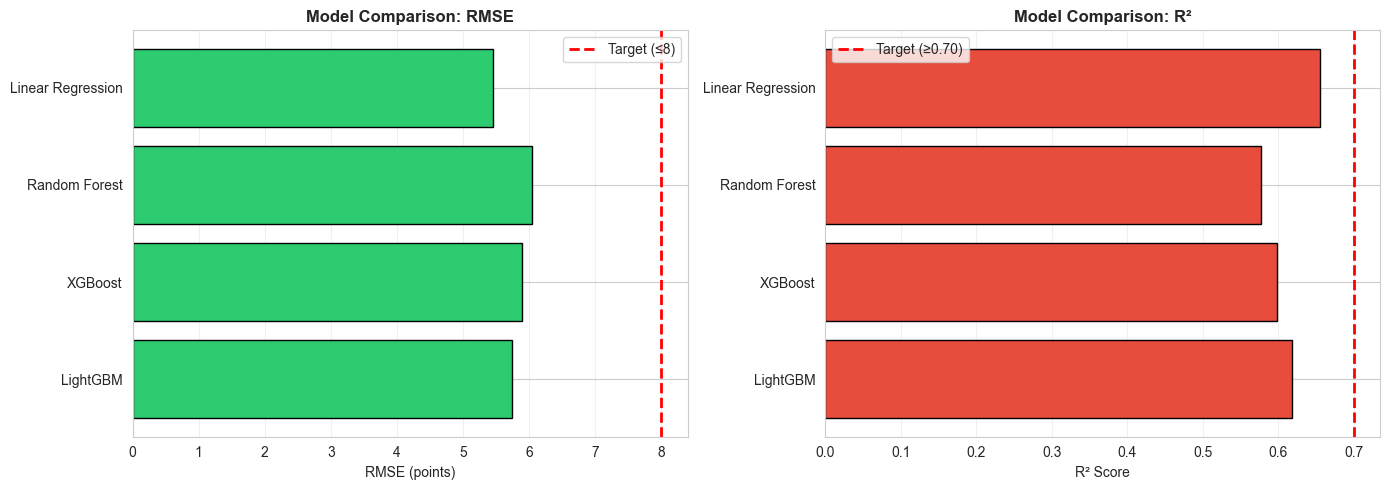

Model comparison visualization saved


In [80]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: RMSE comparison
colors_rmse = ['#e74c3c' if x > 8 else '#2ecc71' for x in comparison_df['RMSE']]
axes[0].barh(comparison_df['Model'], comparison_df['RMSE'], color=colors_rmse, edgecolor='black')
axes[0].axvline(x=8, color='red', linestyle='--', linewidth=2, label='Target (≤8)')
axes[0].set_xlabel('RMSE (points)')
axes[0].set_title('Model Comparison: RMSE', fontweight='bold')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Plot 2: R² comparison
colors_r2 = ['#e74c3c' if x < 0.70 else '#2ecc71' for x in comparison_df['R²']]
axes[1].barh(comparison_df['Model'], comparison_df['R²'], color=colors_r2, edgecolor='black')
axes[1].axvline(x=0.70, color='red', linestyle='--', linewidth=2, label='Target (≥0.70)')
axes[1].set_xlabel('R² Score')
axes[1].set_title('Model Comparison: R²', fontweight='bold')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig(config.FIGURES_DIR / 'readiness_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Model comparison visualization saved")